# Time Series Forecasting

## Imports

In [62]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima import auto_arima


In [63]:
data = pd.read_csv('../data/raw/sales.csv')

In [64]:
data.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [65]:
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

In [66]:
sales_data = data["sales"]
sales_data.head()

date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Name: sales, dtype: float64

In [67]:
def create_plot(to_plot, figsize = (15,10), decompose = pd.Series()):
    fig, axis = plt.subplots(figsize = figsize)
    sns.lineplot(data = to_plot)
    if not decompose.empty:
        sns.lineplot(data = decompose)

    plt.tight_layout()

    plt.show()


In [68]:
def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

In [69]:
def create_arima(data, periods, season = False, tracing = True):
    model = auto_arima(
        y = data,
        seasonal = season,
        trace = tracing,
        m = periods
    )
    forecast = model.predict(20)

    return forecast

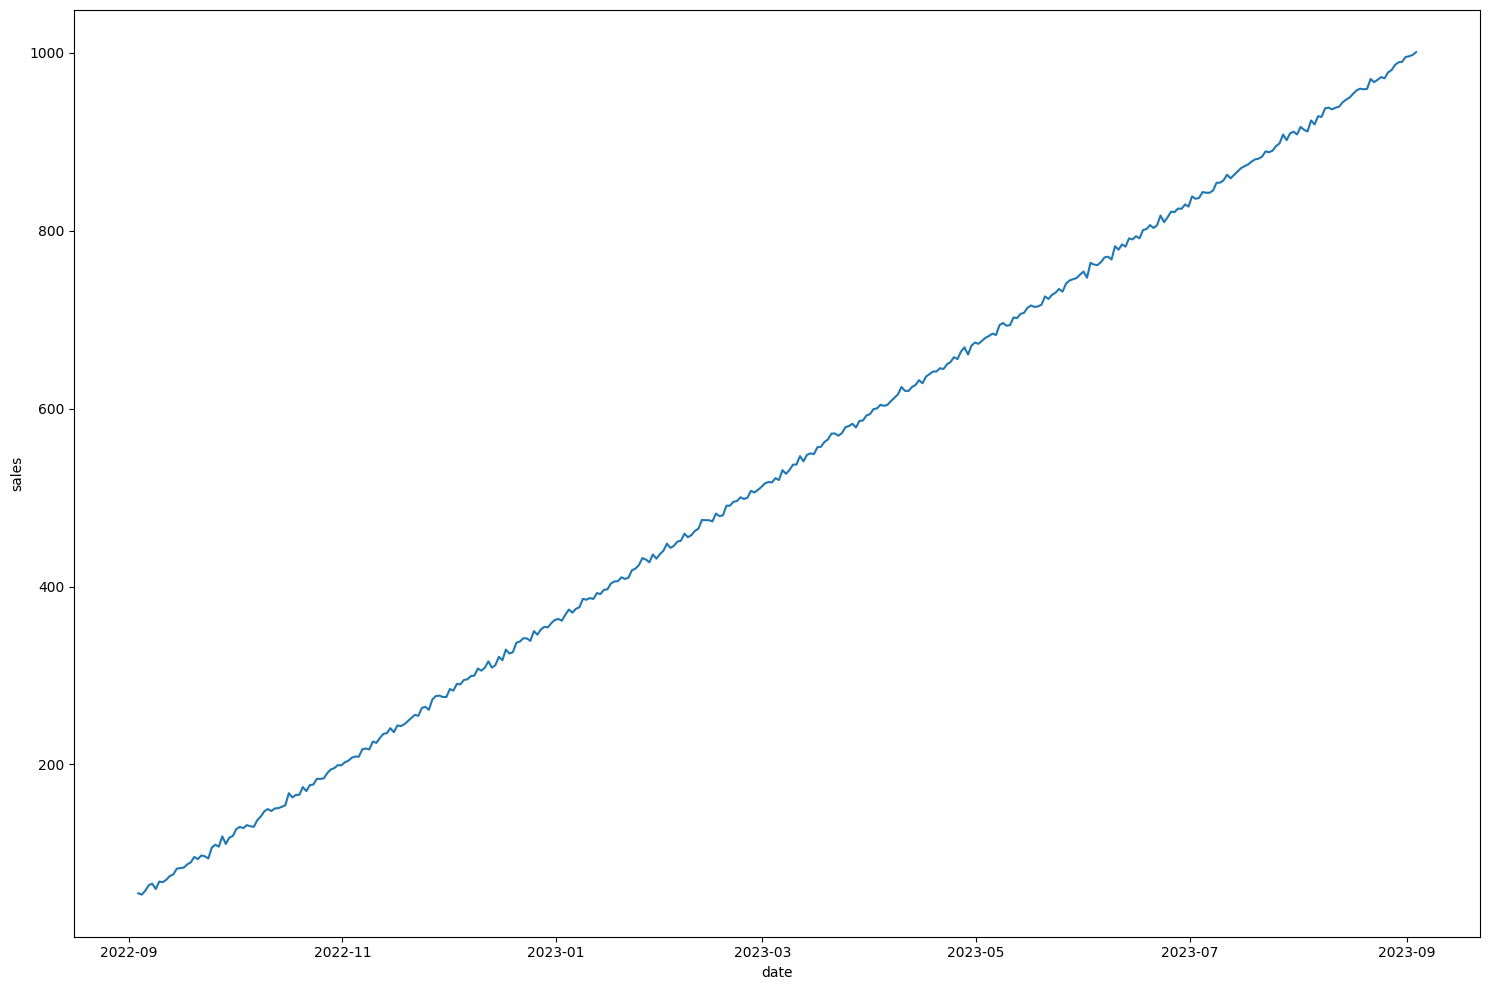

In [70]:
create_plot(
    to_plot = sales_data,
)

In [71]:
test_stationarity(sales_data)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

In [72]:
decomp = seasonal_decompose(sales_data)
decomp

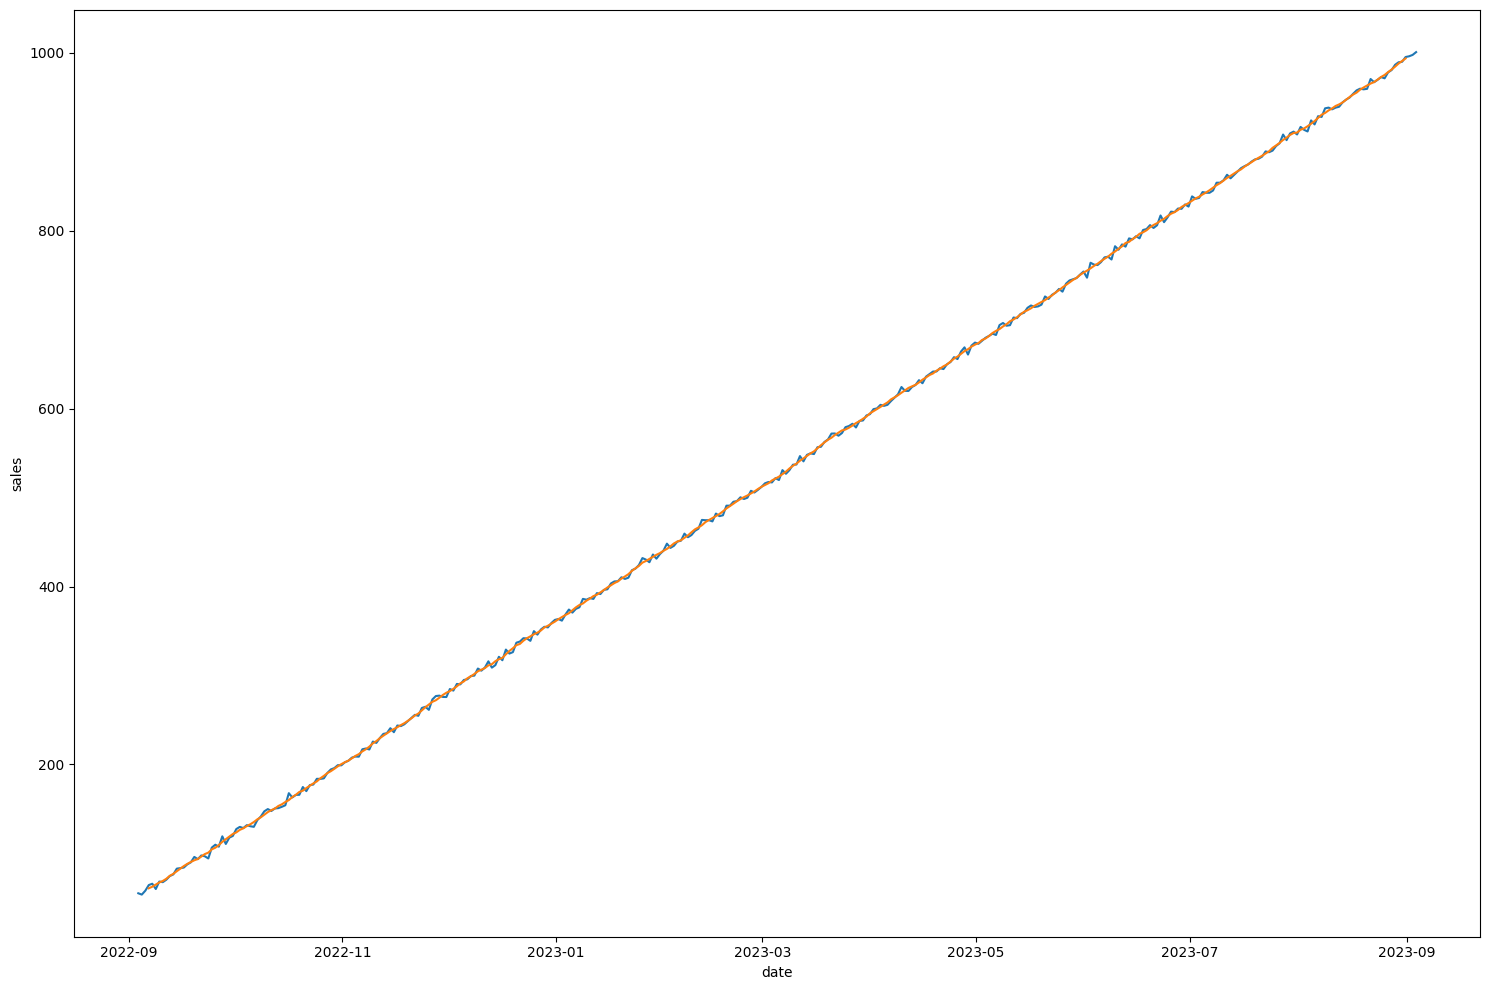

In [73]:
create_plot(
    to_plot= sales_data,
    decompose = decomp.trend
)

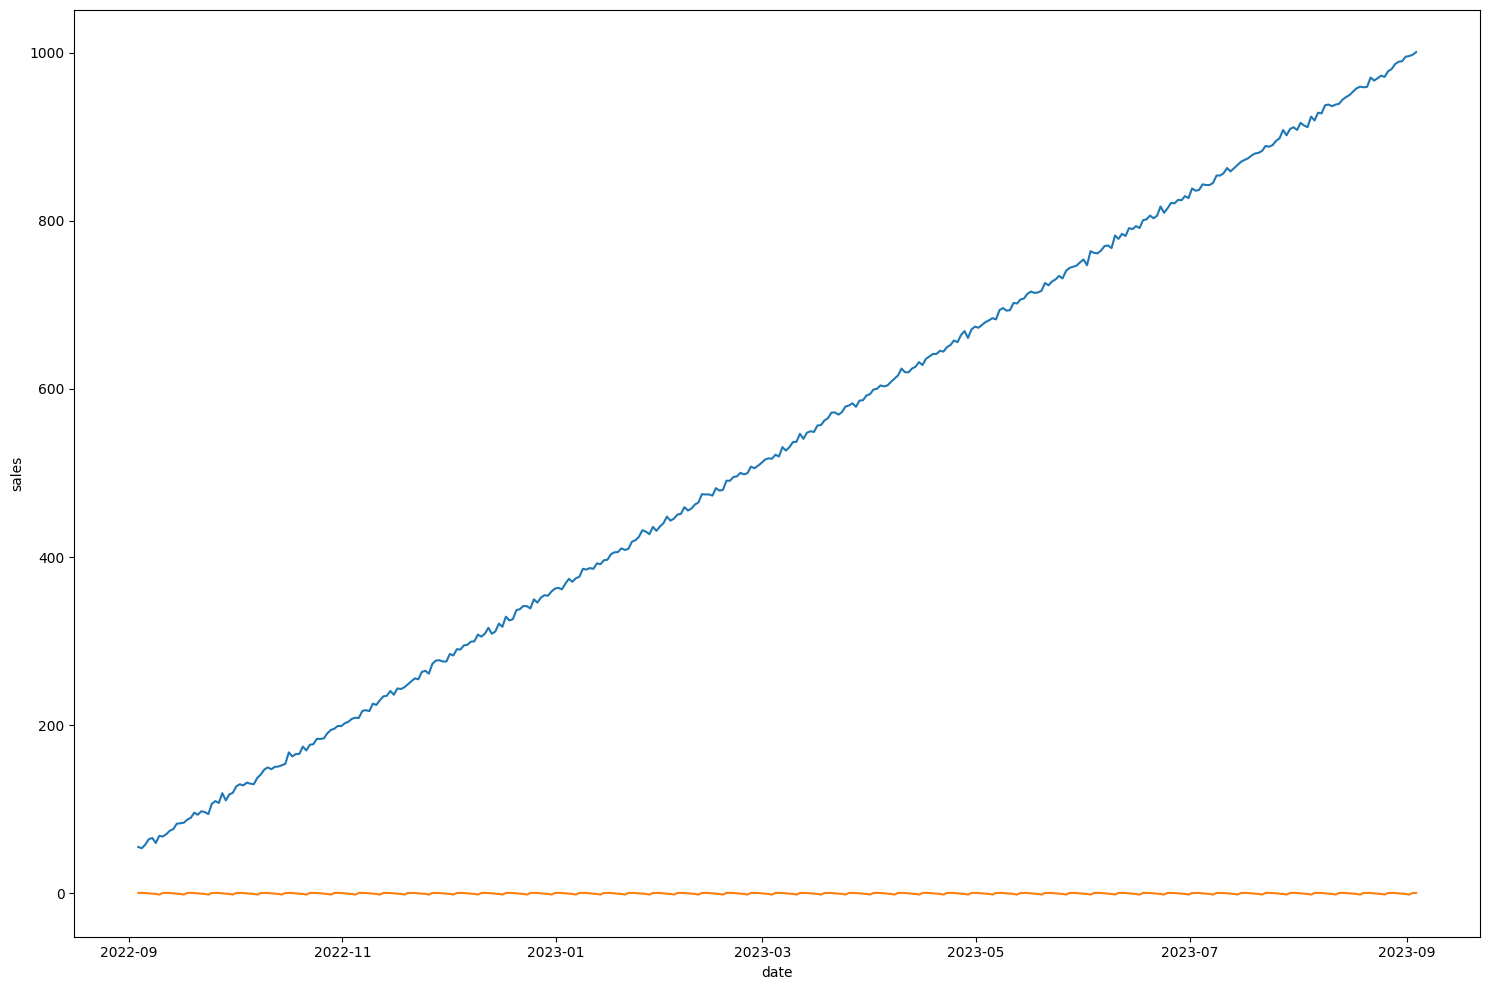

In [74]:
create_plot(
    to_plot= sales_data,
    decompose = decomp.seasonal
)

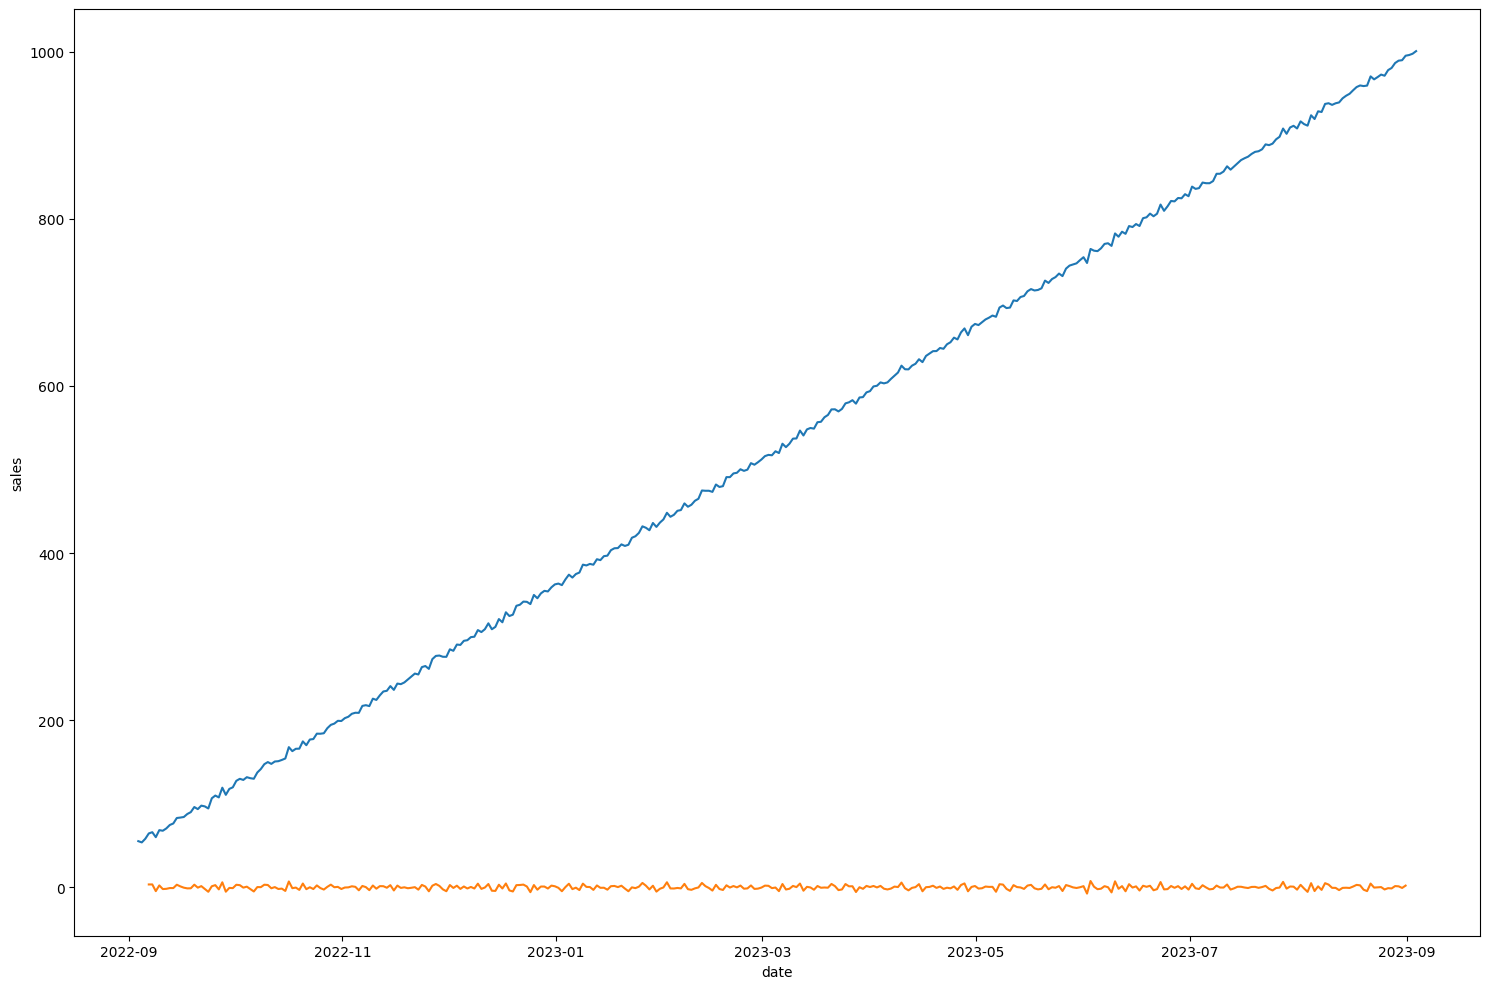

In [75]:
create_plot(
    to_plot= sales_data,
    decompose = decomp.resid
)

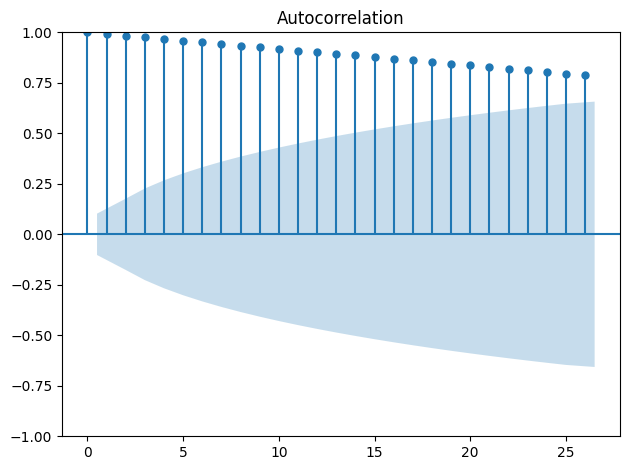

In [76]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(sales_data)

plt.tight_layout()

plt.show()

In [77]:
forecast = create_arima(
    data = sales_data,
    periods = 7,
)

f:\Documentos\Cursos\4geeks\4geeks-ml-template-prjs\.env-ml-prjs\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1843.274, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2096.542, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1970.972, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1839.586, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2209.657, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1839.552, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1841.532, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1843.586, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1839.607, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1922.648, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.24 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.781 seconds


In [78]:
forecast

2023-09-04 17:10:08.079328    1002.158148
2023-09-05 17:10:08.079328    1004.831669
2023-09-06 17:10:08.079328    1007.423289
2023-09-07 17:10:08.079328    1010.021630
2023-09-08 17:10:08.079328    1012.619419
2023-09-09 17:10:08.079328    1015.217254
2023-09-10 17:10:08.079328    1017.815084
2023-09-11 17:10:08.079328    1020.412915
2023-09-12 17:10:08.079328    1023.010746
2023-09-13 17:10:08.079328    1025.608577
2023-09-14 17:10:08.079328    1028.206409
2023-09-15 17:10:08.079328    1030.804240
2023-09-16 17:10:08.079328    1033.402071
2023-09-17 17:10:08.079328    1035.999902
2023-09-18 17:10:08.079328    1038.597733
2023-09-19 17:10:08.079328    1041.195564
2023-09-20 17:10:08.079328    1043.793395
2023-09-21 17:10:08.079328    1046.391226
2023-09-22 17:10:08.079328    1048.989057
2023-09-23 17:10:08.079328    1051.586888
Freq: D, dtype: float64

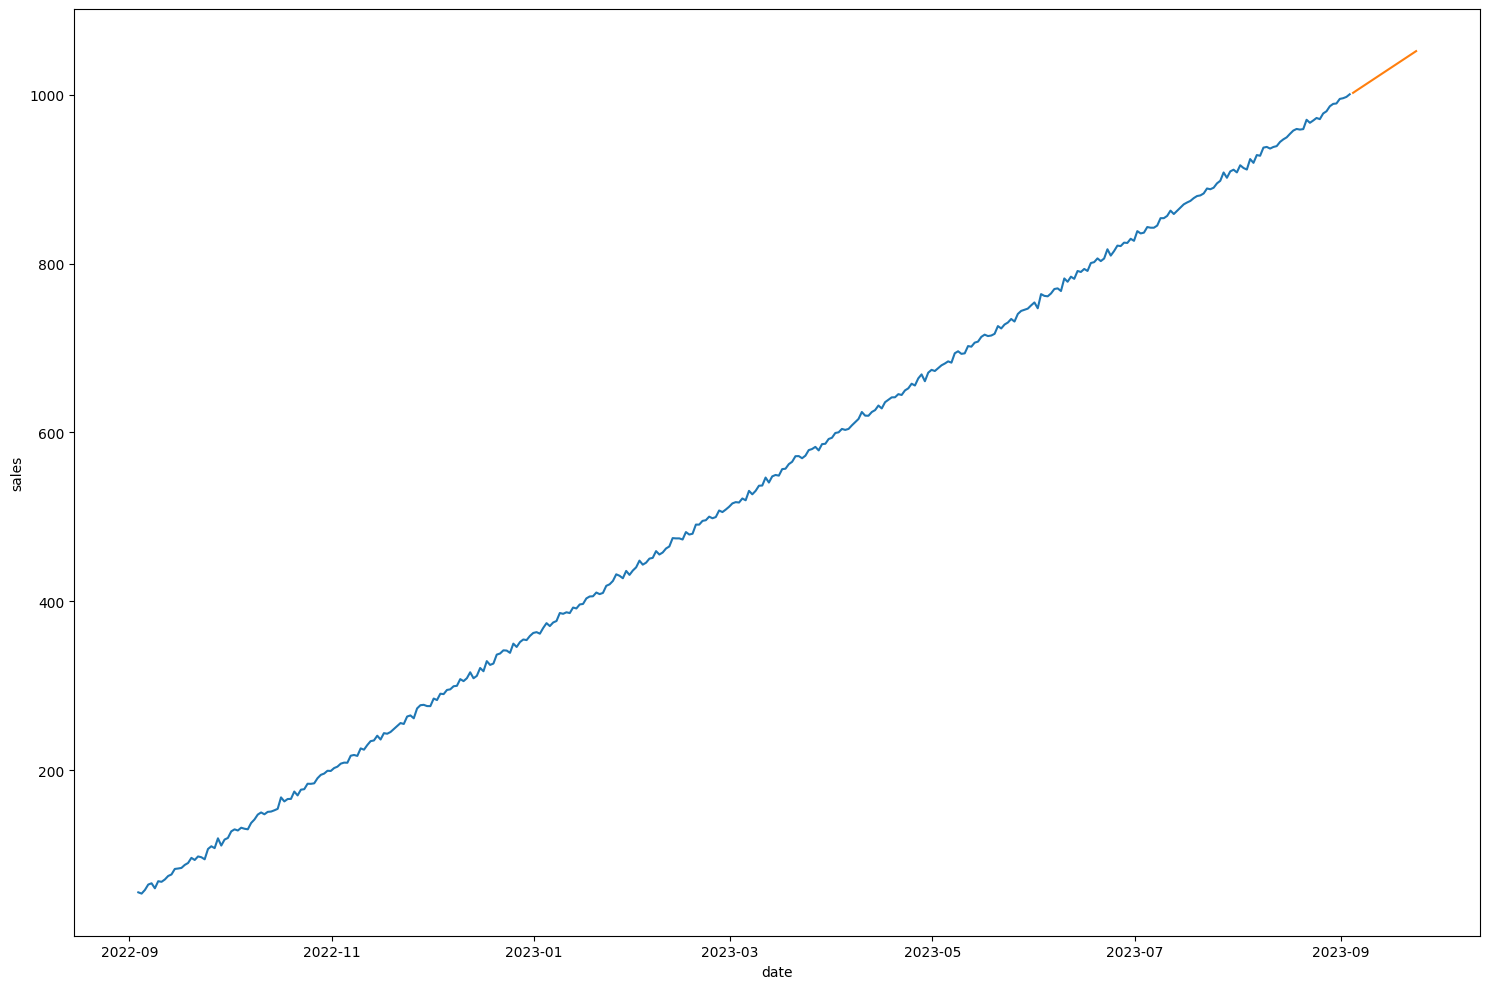

In [79]:
create_plot(
    to_plot = sales_data,
    decompose = forecast
)